In [1]:
#######################
######  Imports   #####
#######################

# Math and dataframes
import numpy as np
import pandas as pd
from collections import Counter

# Basic plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Bokeh plots
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook, export_png
from sklearn.manifold import TSNE
output_notebook()

# Natural language processing tools (NLP)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text

Loading BokehJS ...

### Vectorization

LSA using TfidfVectorizer with bigrams, cutting off infrequent words (min_df=2) was found to be the most interpretable results from a human perspective. Unfortunately, the addition of both these parameters lead to a poor amount explained variance, because we are only including a small subsection of the available data.

In [2]:
# Create a list of stop_words that are: stop_words = (nltk_english + [list of custom stop words])
my_stop_words = text.ENGLISH_STOP_WORDS.union(['flash', 'daily', 'year', 'old', 'man', 'woman', 'like'])

In [3]:
# Read in the dataframe that we are going to work on
df = pd.read_csv('data/2020/merge_clean_2020.csv')


# Select the vectorizer and parameters
# It looks like the best parameters for interpretibility is:
vectorizer = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(2,2), min_df=2)

### Fit and transform the data into a vectorized dataframe
# vect_series is a placeholder to turn into a dataframe: dfvect
# vect_series = vectorizer.fit_transform(df['Title'].values.astype('U'))
doc_word = vectorizer.fit_transform(df['Title'])
df_doc_word = pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names())

In [4]:
# Check shapes (observations, words/n-grams)
doc_word.shape

(36261, 20774)

### Topic Modeling: LSA/SVD

In [5]:
# Decide on how many topics we want
n_topics = 6

In [6]:
# Define how many components should be inputted into the LSA model
lsa_model = TruncatedSVD(n_components=n_topics, n_iter=5, random_state=42)

# Save the transformation as doc_topic: a document(row) by topic(column) matrix
doc_topic = lsa_model.fit_transform(doc_word)

In [7]:
# This lists the explained variance per component (from highest to lowest)
lsa_model.explained_variance_

array([0.00200934, 0.00196997, 0.0016723 , 0.00144429, 0.00135858,
       0.00129507])

Text(0, 0.5, 'Cumulative Explained Variance')

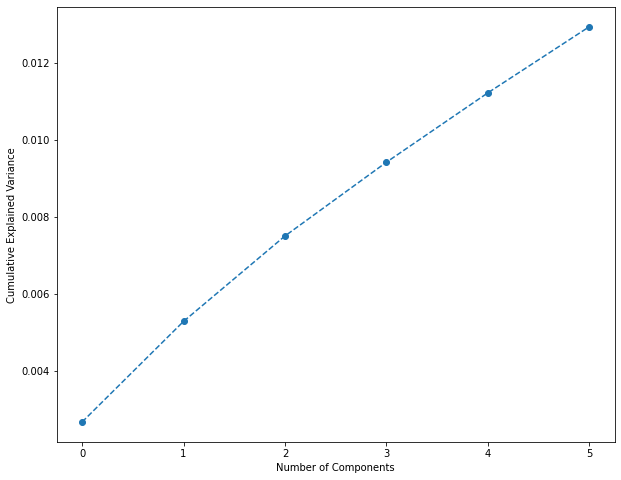

In [8]:
# Plot a figure of cumulative explained variance
plt.figure(figsize = (10,8))
plt.plot(lsa_model.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

### Looking at Topics

In [9]:
# Label the topics as topic_n
prefix_string = 'topic_'
topic_index = [prefix_string+str(i+1) for i in range(n_topics)]

In [10]:
# Create a topic-word matrix: identifies associations of words to each topic

topic_word = pd.DataFrame(lsa_model.components_.round(4),
             index = topic_index,
             columns = df_doc_word.columns)

topic_word

,abandoned trump,abide peace,ability linked,ability state,able eat,able hear,able speak,able talk,able turn,able walk,...,zoom class,zoom classes,zoom court,zoom drug,zoom hearing,zoom home,zoom meeting,zoom security,zoom video,zoom worth
topic_1,0.0000,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0001,-0.0,-0.0,0.0
topic_2,0.0000,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,...,0.0,0.0000,-0.0,0.0,-0.0,-0.0,-0.0000,0.0,0.0,0.0
topic_3,0.0000,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0000,-0.0,0.0,0.0,0.0,0.0000,0.0,-0.0,-0.0
topic_4,0.0001,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,-0.0,-0.0000,0.0,0.0,0.0,-0.0,-0.0001,-0.0,0.0,-0.0
topic_5,-0.0000,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,0.0,0.0001,0.0,0.0,-0.0,-0.0,0.0073,-0.0,0.0,0.0
topic_6,0.0000,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,...,0.0,-0.0000,-0.0,-0.0,-0.0,-0.0,0.0000,-0.0,0.0,0.0


In [11]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [12]:
display_topics(lsa_model, df_doc_word.columns, 10)


Topic  0
toilet paper, paper aisle, birth toilet, run toilet, paper shortage, roll toilet, carrying toilet, police department, paper stolen, paper hand

Topic  1
white house, trump white, house press, president trump, press secretary, house trump, black matter, paw patrol, new york, trump administration

Topic  2
new york, york city, york times, york state, york police, conference new, trump new, black matter, president trump, city mayor

Topic  3
president trump, trump campaign, trump said, black matter, amid pandemic, trump advice, border wall, corona virus, fox news, trump election

Topic  4
police say, trump campaign, home police, wear mask, climate change, hand police, eating police, smelled horrible, horrible police, store police

Topic  5
black matter, social media, matter movement, supporting black, support black, stay home, matter organizer, matter protest, matter rally, climate change


### SVD: Decomposed Matrices

In [13]:
# Shows similarity between different components
Vt = pd.DataFrame(doc_topic.round(5),
                  index = df['Title'],
                  columns = topic_index)

Vt

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
Title,,,,,,
Mentally Unbalanced Man Still Waiting For The Right Trump Comment Incite Him,0.0,0.00001,-0.00000,0.00003,-0.00001,-0.00000
Trump Unable Produce Certificate Proving Not Pile,-0.0,0.00000,0.00000,0.00000,-0.00000,-0.00000
Too Bad Actually Groom Any With,0.0,-0.00000,-0.00000,0.00000,-0.00000,-0.00000
Break Silence Chef for Toxic Workplace Culture,-0.0,-0.00000,0.00000,-0.00000,-0.00000,-0.00000
How Fix The Financial Crisis,0.0,0.00021,0.00769,-0.00025,0.00001,-0.00022
...,...,...,...,...,...,...
Man Million for art gallery painting,-0.0,-0.00000,-0.00000,-0.00000,0.00000,-0.00000
Man Million for painting,-0.0,-0.00000,-0.00000,-0.00000,0.00000,-0.00000
Meet the scientist trying travel back time,-0.0,-0.00000,-0.00000,-0.00000,0.00000,-0.00000


In [14]:
Vt.to_csv('data/2020/doc_topic_matrix_2020.csv', index=False)

In [15]:
cos_Vt = pd.DataFrame(cosine_similarity(Vt))
cos_Vt

,0,1,2,3,4,5,6,7,8,9,...,36251,36252,36253,36254,36255,36256,36257,36258,36259,36260
0,1.000000,0.0,0.0,0.0,-0.021536,0.0,0.0,0.0,0.0,0.052222,...,0.0,0.0,0.066865,0.0,0.0,0.0,0.0,0.0,0.0,0.134840
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,-0.021536,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,-0.027061,...,0.0,0.0,-0.156387,0.0,0.0,0.0,0.0,0.0,0.0,0.024974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36256,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
36257,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
36258,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
36259,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### Word Frequency Distribution

In [16]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [17]:
def get_top_n_word_freq(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    top_word_freq = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_freq.append(np.flip(np.sort(temp_vector_sum)[0][-n:],0))
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(topic_words)
    return top_words, top_word_freq

In [18]:
lsa_topic_matrix = lsa_model.fit_transform(doc_word)
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [19]:
words_in_topics, word_freq = get_top_n_word_freq(10, lsa_keys, doc_word, vectorizer)

df_word_freq = pd.DataFrame()
df_word_freq['words'] = ''
df_word_freq['frequency'] = np.nan
df_word_freq['topic'] = np.nan

for topic_idx in range(len(words_in_topics)):
    for word, freq in zip(words_in_topics[topic_idx], word_freq[topic_idx]):
        df_word_freq = df_word_freq.append({'words': word, 'frequency': freq, 'topic': int(topic_idx)}, ignore_index=True)

In [20]:
df_word_freq.head(50)

,words,frequency,topic
0,toilet paper,112.868817,0.0
1,police department,33.186386,0.0
2,amid covid,26.181707,0.0
3,city council,15.427126,0.0
4,parking lot,14.709765,0.0
5,trial combat,13.238635,0.0
6,jail time,13.028350,0.0
7,police ask,10.363456,0.0
8,stuck nose,10.049250,0.0
9,police stop,9.902838,0.0


In [21]:
# Outputs the top word frequency (tf-idf) from each topic
df_word_freq.groupby(['topic'], sort=False)['frequency'].max()

topic
0.0    112.868817
1.0    129.788307
2.0    101.872282
3.0     90.874510
4.0     79.446514
5.0     71.548368
Name: frequency, dtype: float64

In [22]:
df_word_freq.to_csv('data/2020/df_word_freq_top10.txt', header=None, index=None, sep=' ', mode='a')

In [23]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, doc_word, vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i), top_n_words_lsa[i])

Topic 0:  toilet paper police department amid covid city council parking lot trial combat jail time police ask stuck nose police stop
Topic 1:  white house trump administration paw patrol world news video game conspiracy theory task force press secretary press conference national guard
Topic 2:  new york supreme court face mask test positive strip club positive covid police chief new jersey trump new bin laden
Topic 3:  president trump amid pandemic trump campaign corona virus super bowl animal crossing space force wearing mask tiger king trump rally
Topic 4:  police say corona beer prime minister high school police arrest grocery store law enforcement black people viral video police brutality
Topic 5:  black matter social media stay home fox news police officer video posted ice cream climate change premier league tested positive


In [24]:
# Print text to help discern the topics by number of headlines (for labeling in next cell)
print('Topic Number: ', lsa_categories)
print('Headlines: ', lsa_counts)

Topic Number:  [3, 2, 5, 4, 1, 0]
Headlines:  [6386, 4775, 7222, 4846, 2372, 10660]


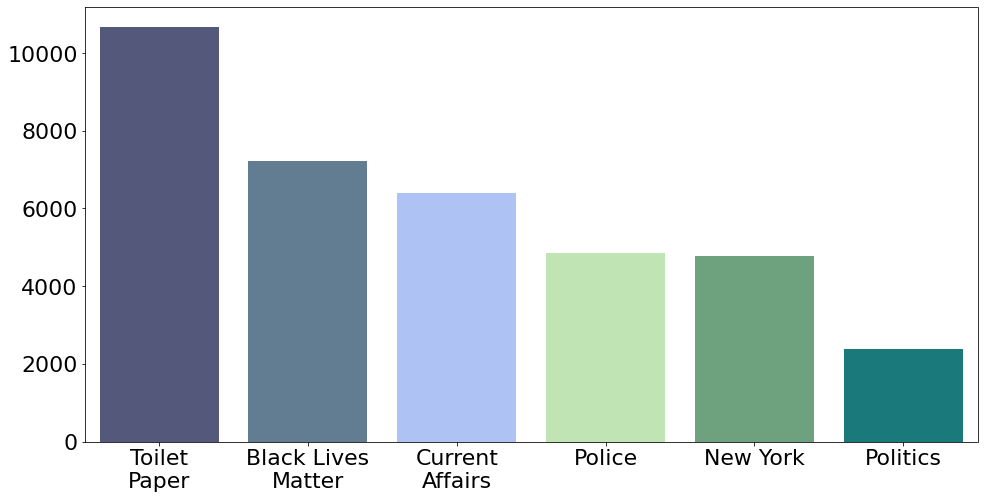

In [25]:
# Word distribution across topics

#labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]
labels = ['Toilet\nPaper',
          'Black Lives\nMatter',
          'Current\nAffairs',
          'Police',
          'New York',
          'Politics']

color_list = ['#4e5481', '#5a7d9a', '#a2bffe', '#bcecac', '#65ab7c', '#0a888a']

sorted_counts = lsa_counts.sort(reverse=True)

fig, ax1 = plt.subplots(figsize=(16,8))
font = {'family': 'avenir', 'weight': 'normal'}
plt.rc('font', **font)

# ax.bar(lsa_categories, lsa_counts);
ax1 = sns.barplot(x = labels,
                 y = lsa_counts,
                 palette = color_list)

# ax.set_xlabel('Topics', fontdict=font, fontsize = 22)
# ax.set_ylabel('Number of Headlines', fontdict=font, fontsize='xx-large')
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)

plt.savefig('images/word_topic_distribution.png', bbox_inches = 'tight', dpi = 300)

### t-SNE Plot

In [26]:
# Variables used for plotting

tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                      n_iter=2000, verbose=1, random_state=0, angle=0.75)

tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 36261 samples in 0.146s...
[t-SNE] Computed neighbors for 36261 samples in 3.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36261
[t-SNE] Computed conditional probabilities for sample 2000 / 36261
[t-SNE] Computed conditional probabilities for sample 3000 / 36261
[t-SNE] Computed conditional probabilities for sample 4000 / 36261
[t-SNE] Computed conditional probabilities for sample 5000 / 36261
[t-SNE] Computed conditional probabilities for sample 6000 / 36261
[t-SNE] Computed conditional probabilities for sample 7000 / 36261
[t-SNE] Computed conditional probabilities for sample 8000 / 36261
[t-SNE] Computed conditional probabilities for sample 9000 / 36261
[t-SNE] Computed conditional probabilities for sample 10000 / 36261
[t-SNE] Computed conditional probabilities for sample 11000 / 36261
[t-SNE] Computed conditional probabilities for sample 12000 / 36261
[t-SNE] Computed conditional probabilities for sa

<ipython-input-27-d2b0c32788a9>:22: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7fb31af8f2b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', 'Toilet Paper', 'Black Lives Matter', 'Current Affairs', 'Police', 'New York', 'Politics'],


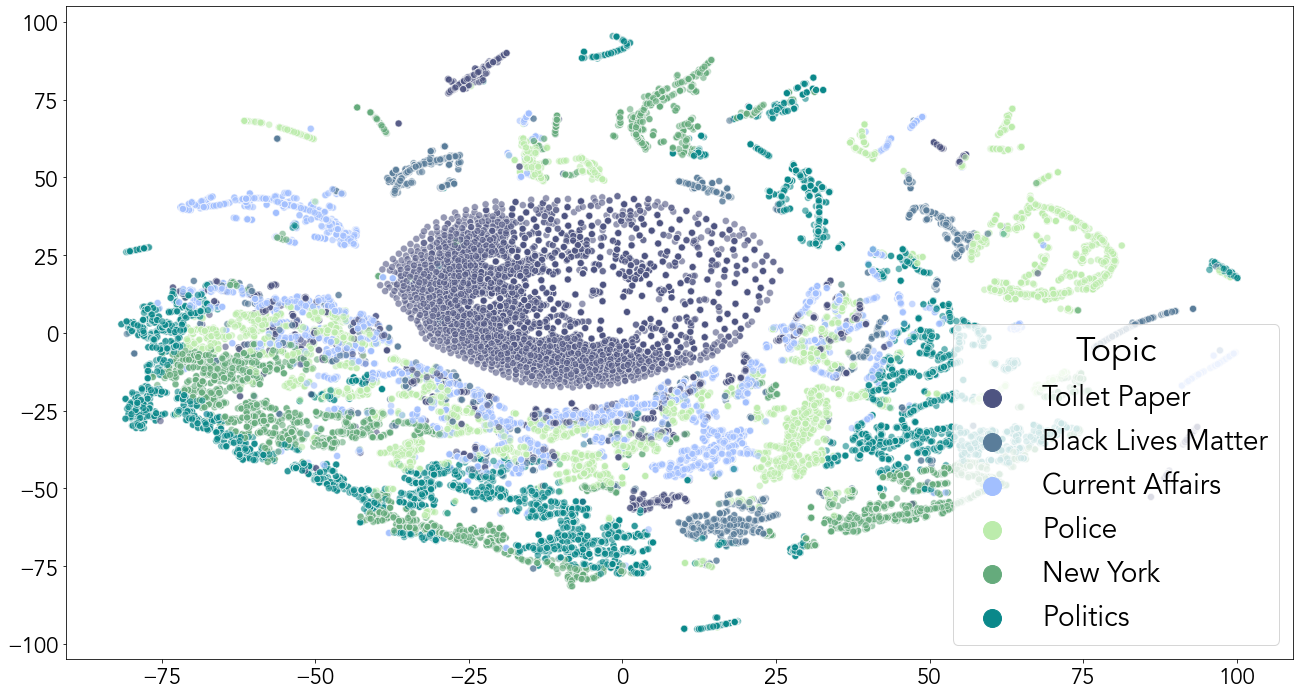

In [27]:
fig, ax2 = plt.subplots(figsize=(22,12))
font = {'family': 'avenir', 'weight': 'normal'}
plt.rc('font', **font)

color_list = ['#4e5481', '#5a7d9a', '#a2bffe', '#bcecac', '#65ab7c', '#0a888a']

ax2 = sns.scatterplot(x = tsne_lsa_vectors[:,0],
                      y = tsne_lsa_vectors[:,1],
                      hue = lsa_keys,
                      palette = color_list,
                      s = 50,
                      markers = ['o', 'o', 'o', 'o', 'o', 'o'],
                      style = lsa_keys,
                      alpha = 0.6)

# Axes properties and labels
ax2.set_xlabel('', fontdict=font, fontsize='xx-large')
ax2.set_ylabel('', fontdict=font, fontsize='xx-large')
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)

plt.legend(['_nolegend_', 'Toilet Paper', 'Black Lives Matter', 'Current Affairs', 'Police', 'New York', 'Politics'],
           title = 'Topic',
           title_fontsize = 34,
           markerscale = 3,
           fontsize = 28,
           loc = 4)

plt.savefig('images/tsne_topic_clusters.png', bbox_inches = 'tight', dpi = 300)

<ipython-input-28-6cdaf5bc3124>:20: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7fb31cf0cb50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', '_nolegend_', '/r/NotTheOnion', '/r/TheOnion'],
<ipython-input-28-6cdaf5bc3124>:20: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7fb31cf0cee0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', '_nolegend_', '/r/NotTheOnion', '/r/TheOnion'],


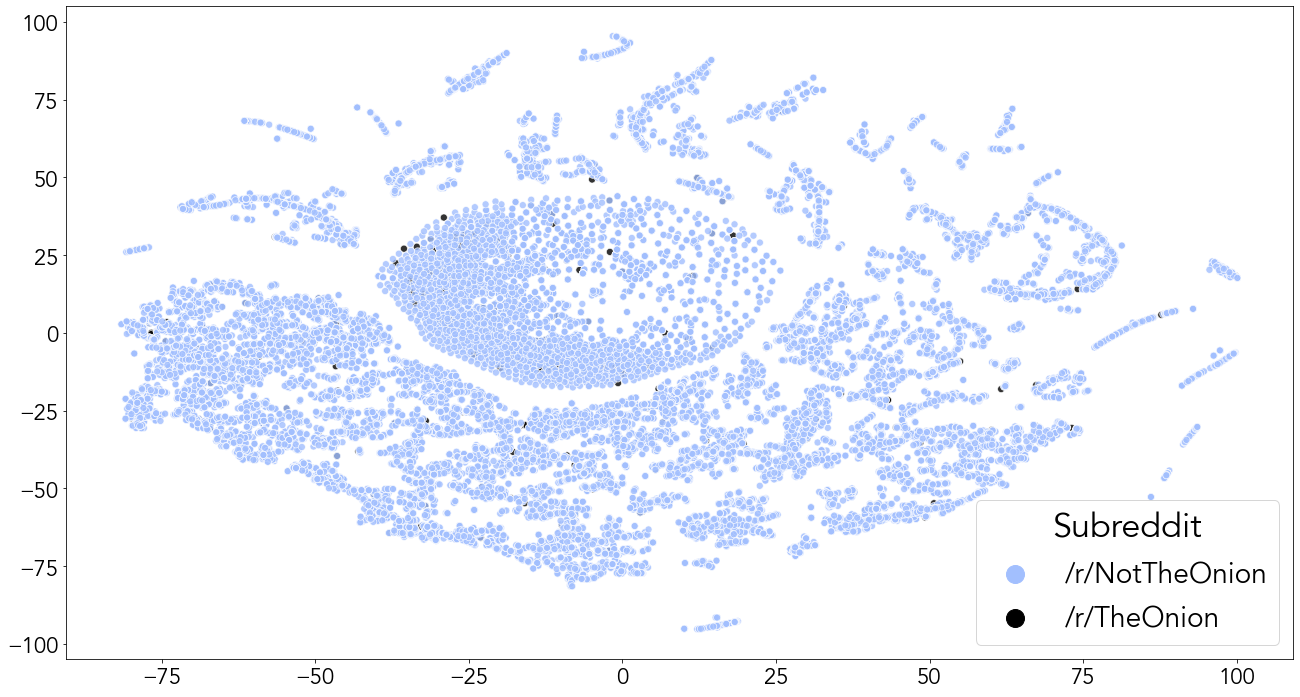

In [28]:
fig, ax3 = plt.subplots(figsize=(22,12))
font = {'family': 'avenir', 'weight': 'normal'}
plt.rc('font', **font)

color_list = ['#a2bffe', '#000000']

ax3 = sns.scatterplot(x = tsne_lsa_vectors[:,0],
                      y = tsne_lsa_vectors[:,1],
                      hue = df['Onion'],
                      palette = color_list,
                      s = 50,
                      alpha = 0.8)

# Axes properties and labels
ax3.set_xlabel('', fontdict=font, fontsize='xx-large')
ax3.set_ylabel('', fontdict=font, fontsize='xx-large')
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)

plt.legend(['_nolegend_', '_nolegend_', '/r/NotTheOnion', '/r/TheOnion'],
           title = 'Subreddit',
           title_fontsize = 34,
           markerscale = 3,
           fontsize = 28,
           loc = 4)

plt.savefig('images/tsne_onion_clusters.png', bbox_inches = 'tight', dpi = 300)

In [29]:
ind1 = df[df.Onion == 1]['Onion'].index
ind2 = df[df.Onion == 0]['Onion'].index

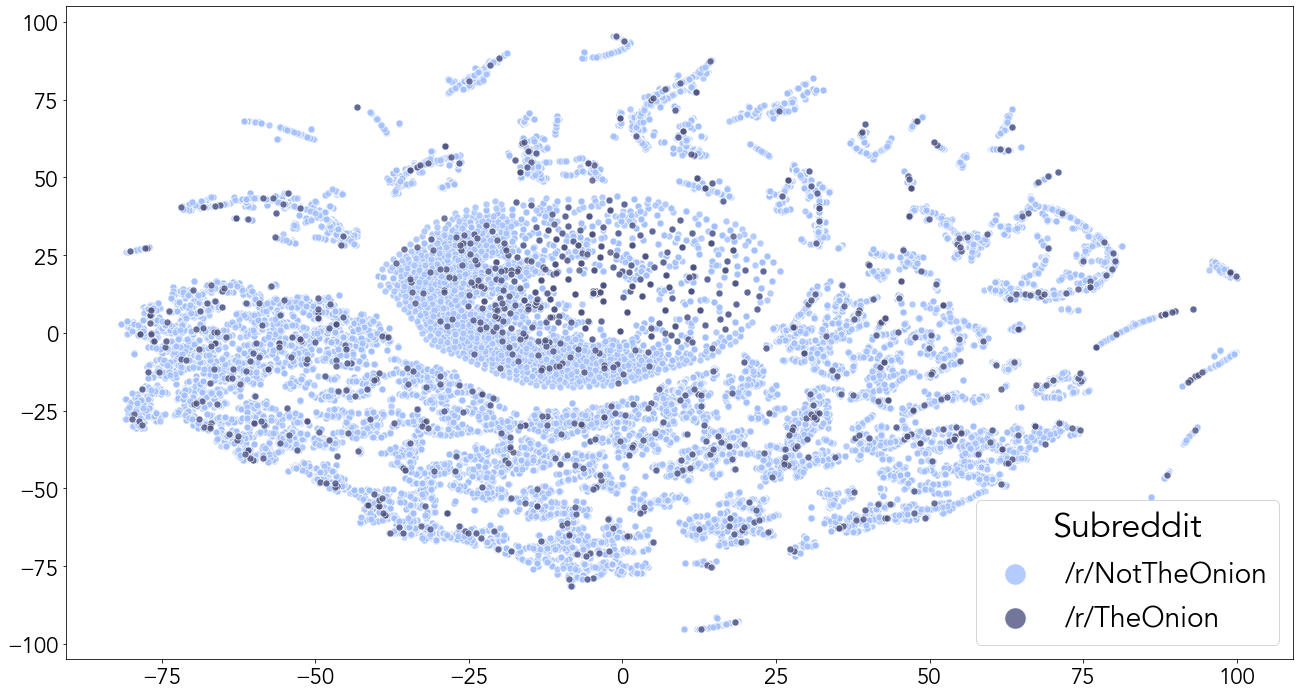

In [40]:
fig, ax3 = plt.subplots(figsize=(22,12))
font = {'family': 'avenir', 'weight': 'normal'}
plt.rc('font', **font)

color_list = ['#a2bffe', '#000000']

ax3 = sns.scatterplot(x = tsne_lsa_vectors[ind2,0],
                      y = tsne_lsa_vectors[ind2,1],
                      #hue = df['Onion'],
                      color = '#a2bffe',
                      s = 50,
                      alpha = 0.8)
sns.scatterplot(x = tsne_lsa_vectors[ind1,0],
                      y = tsne_lsa_vectors[ind1,1],
                      #hue = df['Onion'],
                      color = '#4e5481',
                      s = 50,
                      alpha = 0.8,
                      ax=ax3)

# Axes properties and labels
ax3.set_xlabel('', fontdict=font, fontsize='xx-large')
ax3.set_ylabel('', fontdict=font, fontsize='xx-large')
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)

plt.legend(['/r/NotTheOnion', '/r/TheOnion'],
           title = 'Subreddit',
           title_fontsize = 34,
           markerscale = 3,
           fontsize = 28,
           loc = 4)

plt.savefig('images/tsne_onion_clusters.png', bbox_inches = 'tight', dpi = 300)